In [1]:
%%html
<!-- Potrzebne dla poprawnego wyświetlania tqdm w VSCode https://stackoverflow.com/a/77566731 -->
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

## Wczytanie zbioru danych
Poniższy kod przygotowuje zbiór danych do przeprowadzenia treningu. Zostały przygotowane dwa scenariusze:

- A2D2
- Cityscapes

Odpowiedni zbiór wystarczy odkomentować w celu przeprowadzenia na nim treningu.

In [2]:
from transforms import *
from utils.encoding import ClassMappeer

from torchvision.datasets import Cityscapes
from datasets import A2D2Dataset

a2d2_root = ".\\data\\a2d2\\"
cityscapes_root = ".\\data\\cityscapes"

#A2D2

# mapper = ClassMappeer(
#     dataset_class=A2D2Dataset,
#     train_transforms=transforms,
#     infer_transforms=transforms_test,
#     reduced_subset=True
#     )

# train_dataset = A2D2Dataset(
#     root=a2d2_root,
#     split='train',
#     transforms=mapper.wrap_train
    
# )

# test_dataset = A2D2Dataset(
#     root=a2d2_root,
#     split='val',
#     transforms=mapper.wrap_train
# )

# Cityscapes

mapper = ClassMappeer(
    dataset_class=Cityscapes,
    train_transforms=transforms,
    infer_transforms=transforms_test,
    reduced_subset=True
    )

train_dataset = Cityscapes(
    root=cityscapes_root,
    split='train',
    target_type="semantic",
    transforms=mapper.wrap_train
)

test_dataset = Cityscapes(
    root=cityscapes_root,
    split='val',
    target_type="semantic",
    transforms=mapper.wrap_train
)

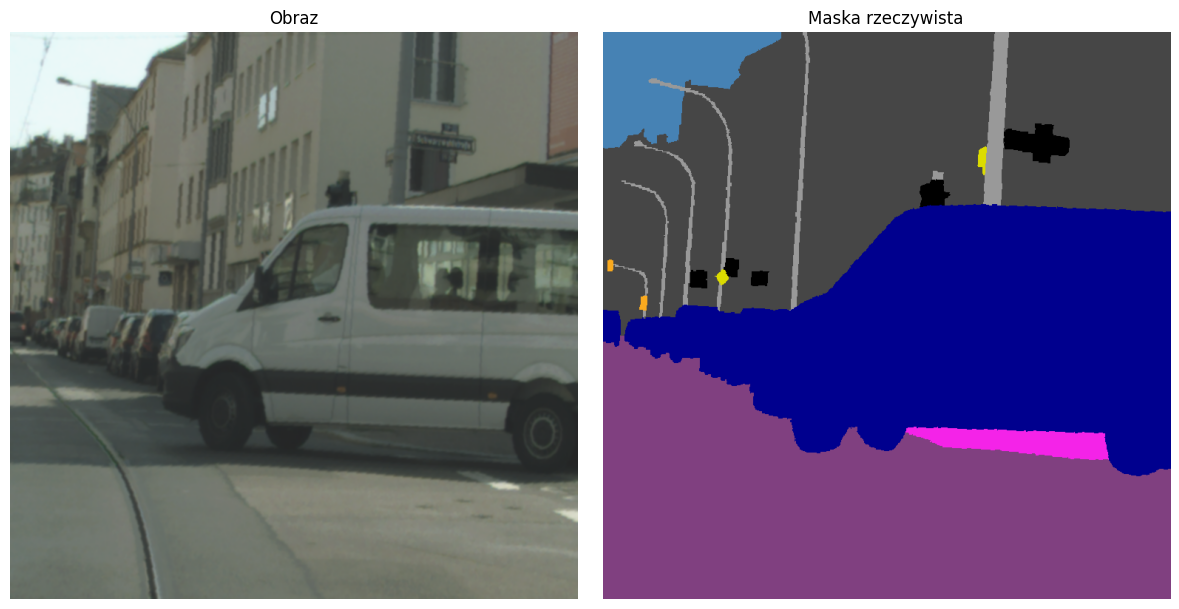

In [3]:
from utils.image import *

image, mask = test_dataset[5]

display_image_and_mask(image=image, mask_true=mask, mapper=mapper)

In [4]:
# Wyświetlanie widocznych na obrazie masek

classes = np.unique(mask)
names = {
    f'{mapper.mapping[int(cid)][1]}'
    for cid in classes
    if int(cid) in mapper.mapping
}
print("\n".join(names))

traffic sign
sidewalk
building
car
traffic light
pole
road
sky
unlabeled


In [5]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=12, 
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4, 
    pin_memory=True,
    drop_last=True
)

## Trening
Poniższy skrypt inicjalizuje model oraz rozpoczyna jego trening przy zadanych wartościach hiperparametrów.

In [ ]:
import os
import pandas as pd

from training.model import ExperimentalModel

import segmentation_models_pytorch as smp

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.tuner import Tuner

backbones = [
    smp.DeepLabV3, smp.DeepLabV3Plus, smp.Linknet, smp.Segformer, smp.Unet, smp.UnetPlusPlus, smp.FPN, smp.PAN, smp.UPerNet, smp.MAnet, smp.PSPNet
]

for backbone in backbones:

    EPOCHS = 50
    T_MAX = EPOCHS * len(train_loader)

    model = ExperimentalModel(
        model_backbone=backbone,
        weights="imagenet",
        encoder="resnext50_32x4d",
        in_channels=3,
        t_max=T_MAX,
        mapper=mapper
    )

    logger = CSVLogger("logs", name=backbone.__name__)

    trainer = pl.Trainer(
        max_epochs=EPOCHS,
        precision=16,
        logger=logger,
        val_check_interval=1.0
    )

    tuner = Tuner(trainer)
    lr_finder = tuner.lr_find(
        model,
        train_dataloaders=train_loader,
        val_dataloaders=test_loader,
        min_lr=1e-6,
        max_lr=1e-2,
        num_training=len(train_loader),
        early_stop_threshold=None
    )

    new_lr = lr_finder.suggestion()

    model.hparams.lr = new_lr

    trainer.fit(
        model,
        train_dataloaders=train_loader,
        val_dataloaders=test_loader,
    )

    # Naprawa pliku z metrykami
    log_path = trainer.logger.log_dir
    log_file_path = os.path.join(".", log_path, "metrics.csv")

    log = pd.read_csv(log_file_path, sep=',')
    log = log.groupby('step').mean()
    log.index.name = "step"

    log.to_csv(os.path.join(".", log_path, f"metrics_{trainer.logger.name}.csv"))


c:\Users\fhcar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precisi

Finding best initial lr:   0%|          | 0/743 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=743` reached.
Learning rate set to 0.0002396306665044245
Restoring states from the checkpoint path at c:\Users\fhcar\Desktop\projekt\.lr_find_96ff0ec3-8c78-47d4-a636-034b5fa04e19.ckpt
Restored all states from the checkpoint at c:\Users\fhcar\Desktop\projekt\.lr_find_96ff0ec3-8c78-47d4-a636-034b5fa04e19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | model      | MAnet     | 146 M  | train
1 | dice_loss  | DiceLoss  | 0      | train
2 | focal_loss | FocalLoss | 0      | train
-------------------------------------------------
146 M     Trainable params
0         Non-trainable params
146 M     Total params
587.659   Total estimated model params size (MB)
294       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
c:\Users\fhcar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\fhcar\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/743 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=743` reached.
Learning rate set to 4.593887440852695e-06
Restoring states from the checkpoint path at c:\Users\fhcar\Desktop\projekt\.lr_find_d9e72038-a5b2-417e-92a4-33a568ac4c1f.ckpt
Restored all states from the checkpoint at c:\Users\fhcar\Desktop\projekt\.lr_find_d9e72038-a5b2-417e-92a4-33a568ac4c1f.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | model      | PSPNet    | 23.9 M | train
1 | dice_loss  | DiceLoss  | 0      | train
2 | focal_loss | FocalLoss | 0      | train
-------------------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.460    Total estimated model params size (MB)
193       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


## Przykłady interferencji
Poniższy kod prezentuje przykłady interferencji.
- Interferencja na `test_dataset` z wyświetlaniem maski rzeczywistej.
- Interferencja na pojedyńczym obrazie ze zbioru testowego.
- Interferencja na własnym obrazie.

In [ ]:
import glob

def find_checkpoints(logs_root):
    checkpoint_files = {}
    logs = glob.glob(os.path.join(logs_root, '*'))
    for log in logs:
        versions = glob.glob(os.path.join(log, 'version_*'))
        for version_pth in versions:
            version = version_pth.split('_')[1]
            checkpoints = glob.glob(os.path.join(version_pth, 'checkpoints', '*.ckpt'))
            for checkpoint in checkpoints:
                checkpoint_files.update({checkpoint: [version]})
    return checkpoint_files

find_checkpoints('.\\logs')

{'.\\logs\\DeepLabV3\\version_0\\checkpoints\\epoch=49-step=37150.ckpt': '0',
 '.\\logs\\DeepLabV3Plus\\version_2\\checkpoints\\epoch=49-step=37150.ckpt': '2',
 '.\\logs\\DeepLabV3Plus\\version_3\\checkpoints\\epoch=49-step=37150.ckpt': '3',
 '.\\logs\\FPN\\version_0\\checkpoints\\epoch=49-step=37150.ckpt': '0',
 '.\\logs\\Linknet\\version_0\\checkpoints\\epoch=49-step=37150.ckpt': '0',
 '.\\logs\\MAnet\\version_0\\checkpoints\\epoch=49-step=37150.ckpt': '0',
 '.\\logs\\PAN\\version_0\\checkpoints\\epoch=49-step=37150.ckpt': '0',
 '.\\logs\\PSPNet\\version_0\\checkpoints\\epoch=49-step=37150.ckpt': '0',
 '.\\logs\\Segformer\\version_0\\checkpoints\\epoch=49-step=37150.ckpt': '0',
 '.\\logs\\Unet\\version_0\\checkpoints\\epoch=49-step=37150.ckpt': '0',
 '.\\logs\\UnetPlusPlus\\version_0\\checkpoints\\epoch=49-step=37150.ckpt': '0',
 '.\\logs\\UPerNet\\version_0\\checkpoints\\epoch=49-step=37150.ckpt': '0'}

In [ ]:
import torch
from utils.image import *
from training.model import ExperimentalModel


import segmentation_models_pytorch as smp

# Załadowanie modelu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ExperimentalModel.load_from_checkpoint(
    model_arch=smp.FPN,
    checkpoint_path=".\\logs\\PAN\\version_0\\checkpoints\\epoch=49-step=37150.ckpt",
    weights="imagenet",
    encoder="resnext50_32x4d",
    in_channels=3,
    mapper=mapper
)

model = model.to(device)

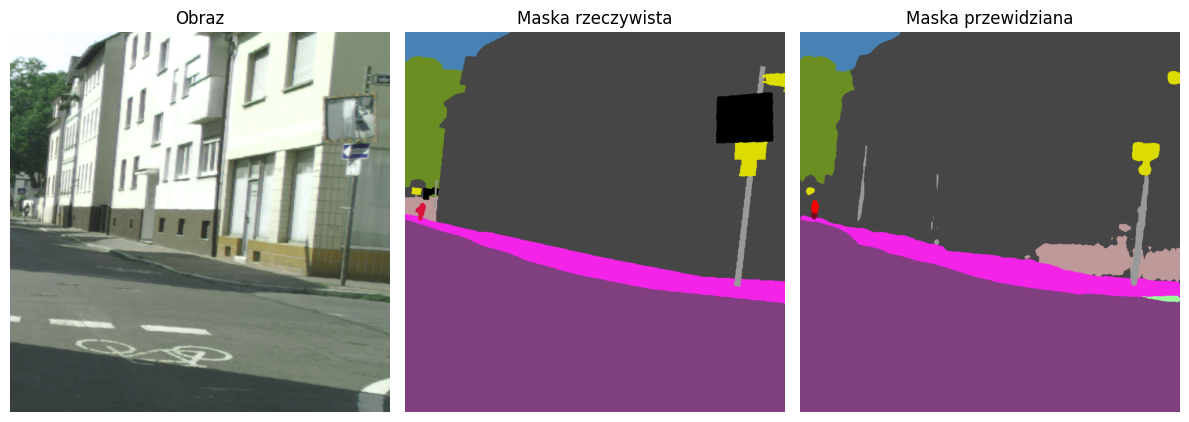

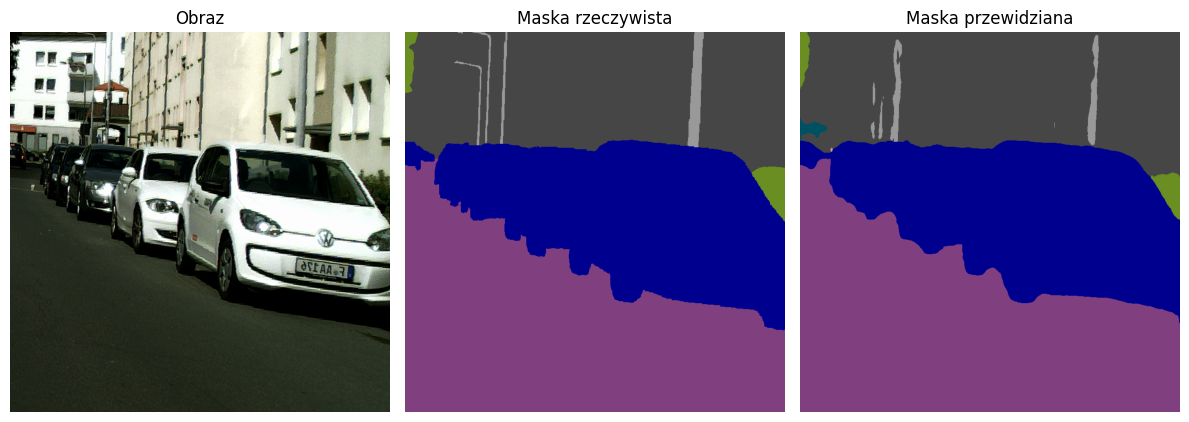

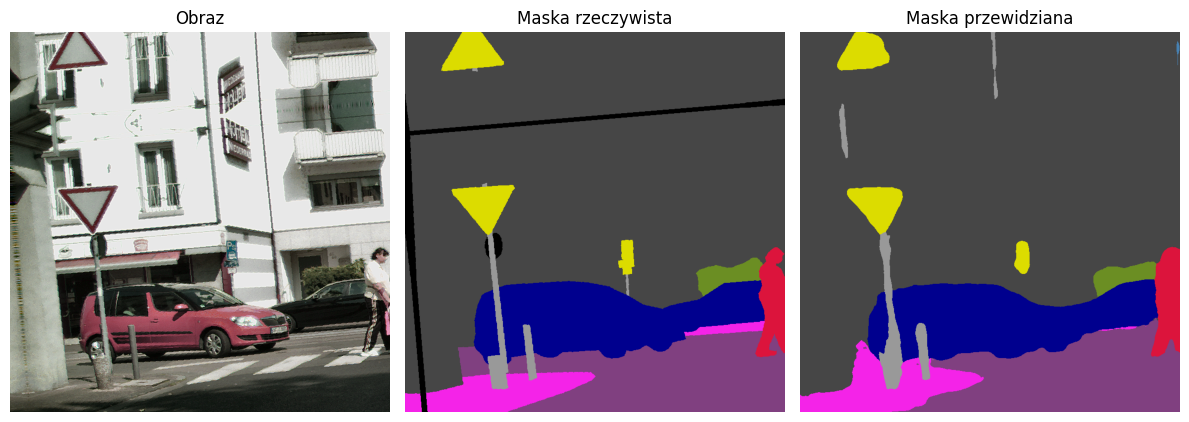

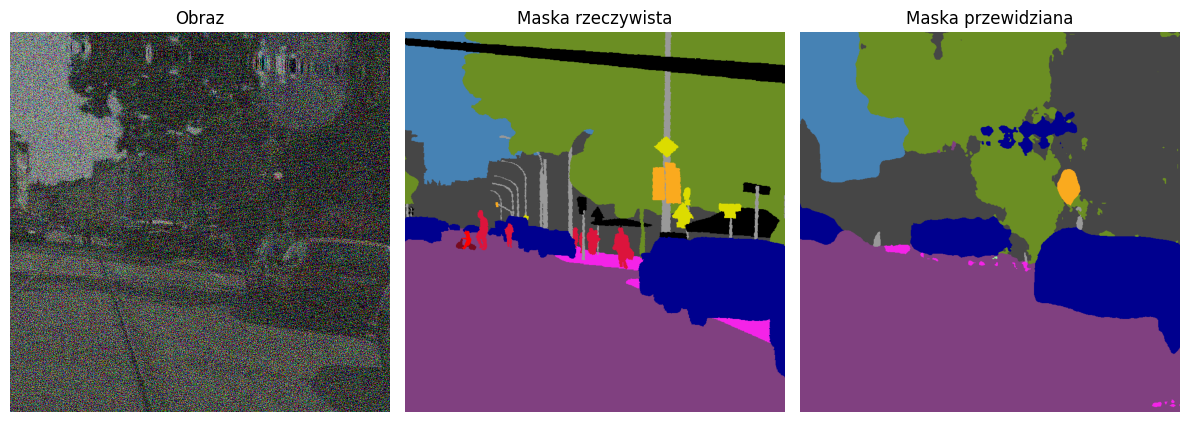

In [28]:
import torch
from utils.image import *

# Cały zbiór walidacyjny

images, masks = next(iter(test_loader))
images = images.to(device)
masks  = masks.to(device)

masks = masks.squeeze(1)

with torch.inference_mode():
    model.eval()
    logits = model(images)

pr_masks = logits.softmax(dim=1).argmax(dim=1)

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx > 4:  # Visualize first 5 samples
        break

    img_cpu  = image.cpu().numpy().transpose(1,2,0)
    gt_cpu   = gt_mask.cpu().numpy()      # (H,W)
    pred_cpu = pr_mask.cpu().numpy()      # (H,W)

    display_image_and_mask(
        image=img_cpu,
        mask_true=gt_cpu,
        mask_pred=pred_cpu,
        mapper=mapper
    )

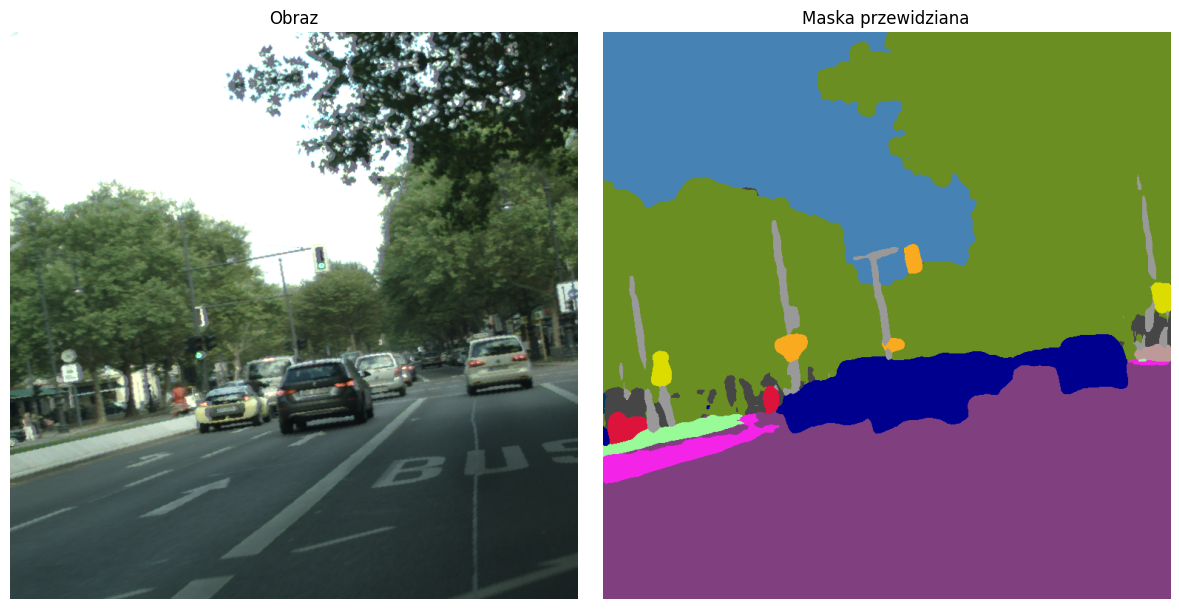

In [29]:
import torch
from torch.utils.data import DataLoader
from utils.image import *

# Custom testowy

test_dataset = Cityscapes(
    root=cityscapes_root,
    split='test',
    target_type="semantic",
    transforms=mapper.wrap_infer
)

single_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

# Inference

images, _ = next(iter(single_loader))
images = images.to(device)

with torch.inference_mode():
    logits = model(images)

pr_masks = logits.softmax(1).argmax(1)

display_image_and_mask(
    image=images[0], 
    mask_pred=pr_masks[0], 
    mapper=mapper
)


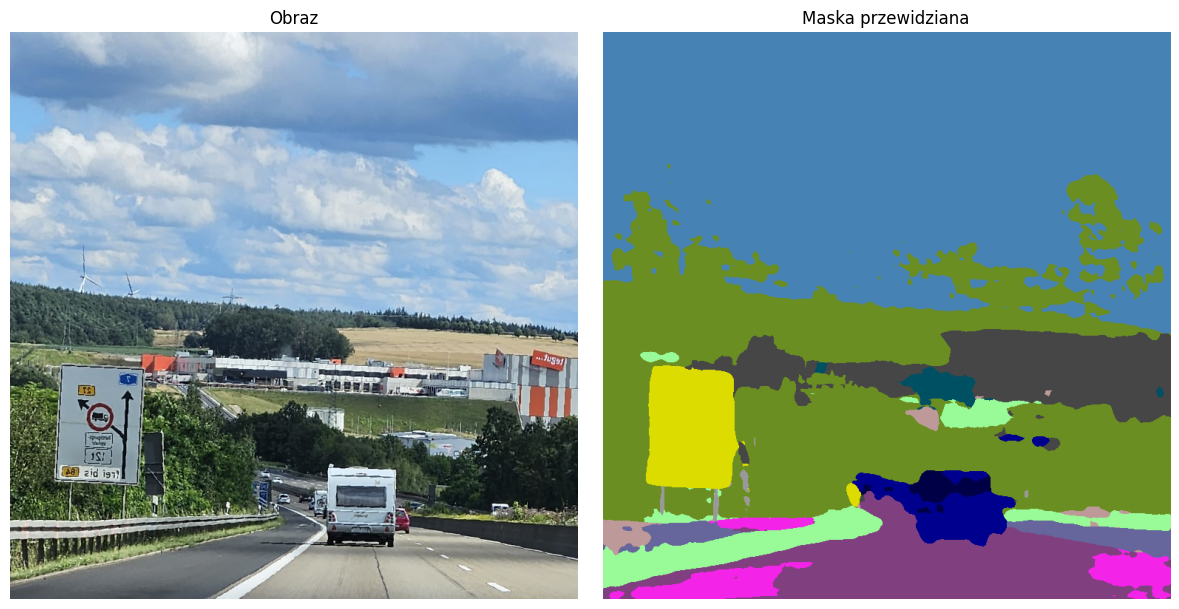

In [36]:
import torch
from PIL import Image
from utils.image import *

# Własny obraz

pil_image = Image.open(r".\test\test2.png")

aug_image = mapper.preprocess_image(img=np.asarray(pil_image))
tensor_image = aug_image.to(device)

with torch.inference_mode():
    logits = model(tensor_image)
    
pr_mask = logits.softmax(1).argmax(1)

display_image_and_mask(
    image=tensor_image, 
    mask_pred=pr_mask, 
    mapper=mapper
)

## Benchmarkt

In [ ]:
import torch
from torch.utils.data import DataLoader
from utils.image import *
from tqdm import tqdm
from torchvision.datasets import Cityscapes

test_dataset = Cityscapes(
    root=cityscapes_root,
    split="test",
    target_type="semantic",
    transforms=mapper.wrap_infer,   # bez augmentacji treningowych
)

single_loader = DataLoader(
    test_dataset,
    batch_size=1,        # batch = 1 scenariusz on-line
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

dummy = torch.randn(1, 3, 1024, 2048, device="cuda")  # batch = 1, 1024×2048

#w warmm up
torch.backends.cudnn.benchmark = True       # autotuner cuDNN
with torch.no_grad():
    for _ in range(10):
        _ = model(dummy)

reps = 800
starter = torch.cuda.Event(True); ender = torch.cuda.Event(True)
timings = []

with torch.no_grad():
    for _ in range(reps):
        starter.record()
        _ = model(dummy)
        ender.record()
        torch.cuda.synchronize()
        timings.append(starter.elapsed_time(ender))  # ms

lat_ms = sum(timings) / len(timings)
print(f"Średnia latencja : {lat_ms:.3f} ms  |  FPS : {1000/lat_ms:.1f}")